In [188]:
import numpy as np
import cv2 as cv
import seaborn as sns
import scipy.fftpack as fft
from sklearn.linear_model import Lasso, LassoCV
from scipy.io import loadmat
from scipy import sparse, ndimage
from numpy import linalg as la, random as rand
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tnrange, tqdm_notebook
from jupyterthemes import jtplot

In [158]:
%matplotlib inline
jtplot.reset()
# plt.switch_backend('Agg')
sns.set()
sns.set_context("notebook")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["figure.figsize"] = (5*16/9, 5)
plt.rcParams["figure.dpi"] = 100

In [171]:
testdir = "D:/Kenneth/Documents/VIP/Datasets/dr2imagenet/TEST"
img_w, img_h, img_ch = 128, 128, 1

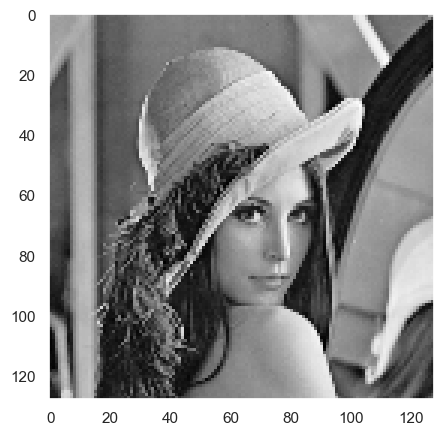

In [172]:
img = cv.imread(testdir + '/lena.png', 0)
img = cv.resize(img, (img_h, img_w))
plt.imshow(img, 'gray')
plt.grid(0)
plt.show()

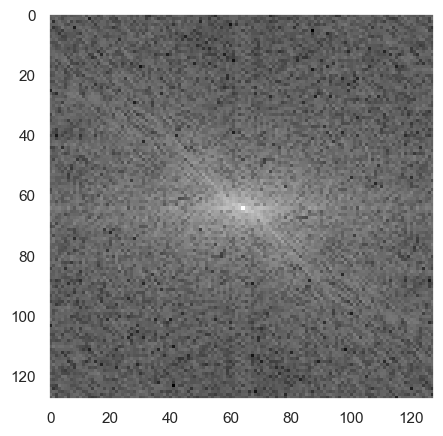

In [173]:
Fimg = fft.fft2(img)
plt.imshow(abs(np.log10(fft.fftshift(Fimg))), 'gray')
plt.grid(0)
plt.show()

In [174]:
def _weights(x, dx=1, orig=0):
    x = x.ravel()
    flx = np.floor((x - orig)/dx).astype('int64')
    alpha = (x - orig - flx*dx)/dx
    return np.hstack((flx, flx + 1)), np.hstack((1 - alpha, alpha))

def generate_center_coords(lx):
    X, Y = np.mgrid[:lx, :lx].astype('float64')
    center = lx/2
    X += 1/2 - center
    Y += 1/2 - center
    return X, Y

def build_proj_op(lx, ndir):
    X, Y = generate_center_coords(lx)
    angles = np.linspace(0, np.pi, ndir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(lx**2)
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle)*X - np.sin(angle)*Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < lx)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i*lx)
        data_inds += list(data_unravel_indices[mask])
    proj_op = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_op

def generate_synthetic_data():
    rs = rand.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l/n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))

In [181]:
l = 128
proj_operator = build_proj_op(l, l//7)
data = img
proj = proj_operator * data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

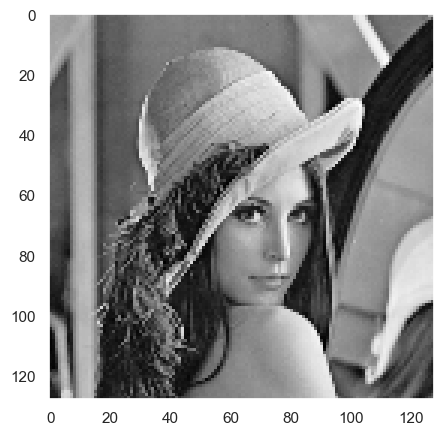

In [182]:
plt.imshow(img, 'gray')
plt.grid(0)
plt.show()

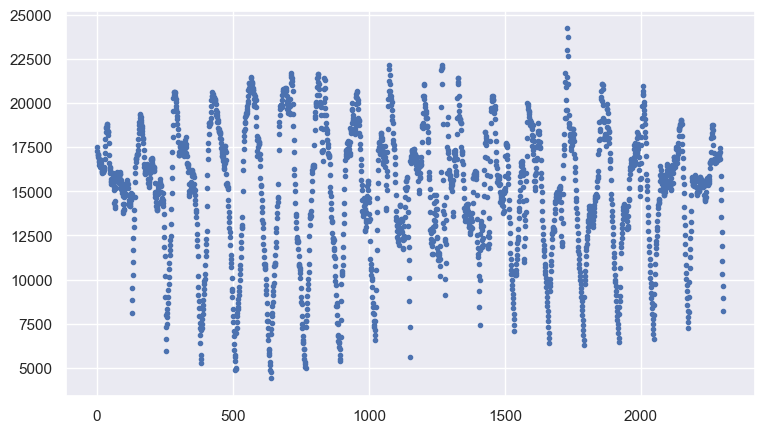

In [183]:
plt.plot(proj.squeeze(), '.')
plt.show()

In [185]:
prob = Lasso(alpha=0.001)
prob.fit(proj_operator, proj.ravel())

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3788550.143457995, tolerance: 3120626.5970851937
  max_iter, tol, rng, random, positive)


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

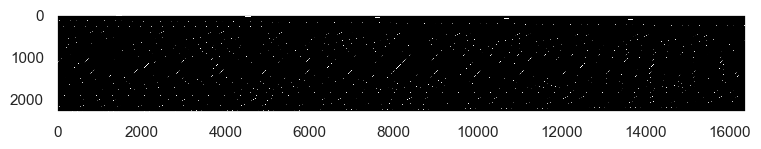

In [186]:
plt.imshow(proj_operator.toarray(), 'gray')
plt.grid(0)
plt.show()

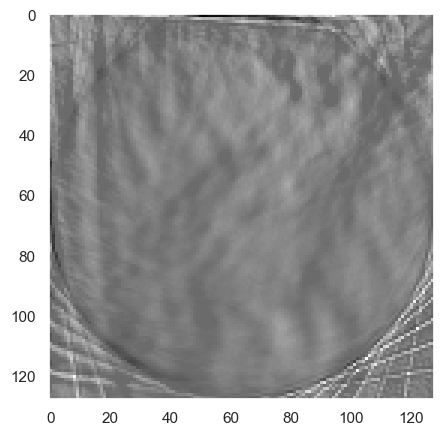

In [187]:
plt.imshow(prob.coef_.reshape(l, l), 'gray', interpolation='nearest')
plt.grid(0)
plt.show()

In [189]:
data = loadmat('results.mat')

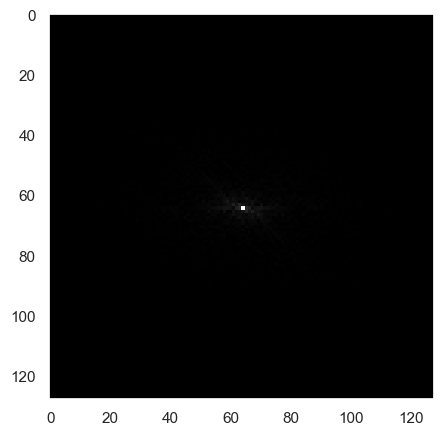

In [201]:
plt.imshow(abs((data['spec'])), 'gray')
plt.grid(0)
plt.show()

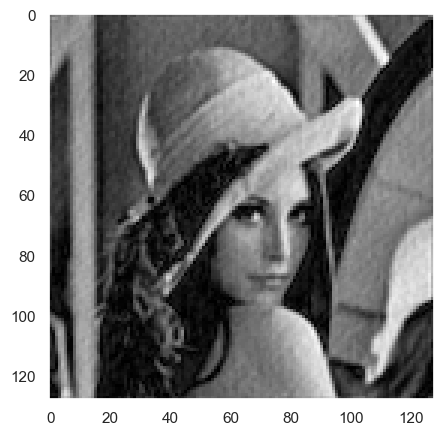

In [202]:
plt.imshow(abs(fft.ifft2(data['spec'])), 'gray')
plt.grid(0)
plt.show()

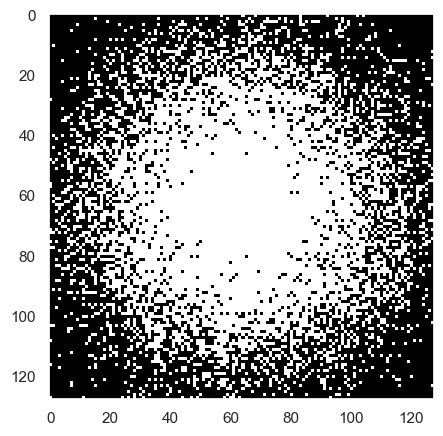

In [208]:
plt.imshow(data['mask'], 'gray')
plt.grid(0)
plt.show()

In [224]:
ri = np.where(data['mask'].ravel() == 1)[0]

In [232]:
comp_spec = abs(fft.ifft2(data['spec'])).ravel()[ri]

In [231]:
sens_mat = fft.dct(np.identity(data['spec'].size))[ri]

In [234]:
prob = LassoCV(cv=5, random_state=0, n_jobs=-1, verbose=1)
prob.fit(sens_mat, comp_spec)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 17.2min finished


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=-1, normalize=False, positive=False,
        precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
        verbose=1)

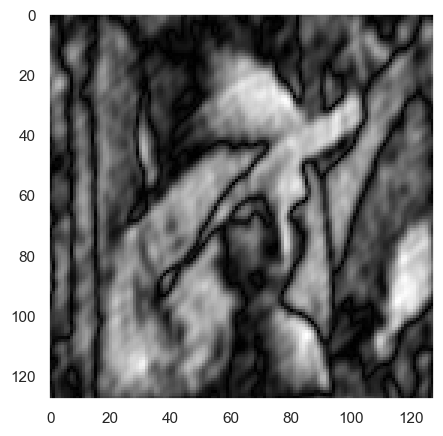

In [242]:
plt.imshow(abs(fft.idct(prob.coef_).reshape(128, 128)), 'gray')
plt.grid(0)
plt.show()